In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
pip install rasterio

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.up(x)

class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        self.w_g = nn.Sequential(
            nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int)
        )
        self.w_x = nn.Sequential(
            nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

import torch.nn as nn
import torch

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=1):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = ConvBlock(ch_in=in_channels, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)
        
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)
        
        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)
        
        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)
        
        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)
        
        self.conv_1x1 = nn.Conv2d(64, out_channels, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        x2 = self.conv2(self.maxpool(x1))
        x3 = self.conv3(self.maxpool(x2))
        x4 = self.conv4(self.maxpool(x3))
        x5 = self.conv5(self.maxpool(x4))
        
        # Decoder + Attention
        d5 = self.upconv5(torch.cat((self.att5(self.up5(x5), x4), self.up5(x5)), dim=1))
        d4 = self.upconv4(torch.cat((self.att4(self.up4(d5), x3), self.up4(d5)), dim=1))
        d3 = self.upconv3(torch.cat((self.att3(self.up3(d4), x2), self.up3(d4)), dim=1))
        d2 = self.upconv2(torch.cat((self.att2(self.up2(d3), x1), self.up2(d3)), dim=1))
        
        d1 = self.conv_1x1(d2)
        
        return torch.sigmoid(d1)  # Output probability map


In [5]:
import torch
import os
import numpy as np
import rasterio
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class SARDEMDataset(Dataset):
    def __init__(self, img_paths, label_paths, transform=None):
        self.img_paths = img_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = tiff.imread(self.img_paths[idx]).astype(np.float32)  # Convert to float32
        label = plt.imread(self.label_paths[idx])

        # Normalize label to 0 or 1
        label = (label > 0.001).astype(np.uint8)

        if self.transform:
            img = self.transform(img)
            label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)  # Ensure float32
        
        return img, label


In [6]:
from sklearn.model_selection import train_test_split

# Paths
img_dir = "/kaggle/input/images/images/images"
label_dir = "/kaggle/input/images/labels/labels"

# List images and labels
img_list = sorted([f for f in os.listdir(img_dir) if f.endswith(".tif")])
label_list = sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])

# Keep only matching pairs
img_paths = [os.path.join(img_dir, f) for f in img_list if f.replace(".tif", ".png") in label_list]
label_paths = [os.path.join(label_dir, f.replace(".tif", ".png")) for f in img_list if f.replace(".tif", ".png") in label_list]

# Train-test split
train_img_paths, test_img_paths, train_label_paths, test_label_paths = train_test_split(img_paths, label_paths, test_size=0.2, random_state=42)

# Data Augmentation & Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create Datasets
train_dataset = SARDEMDataset(train_img_paths, train_label_paths, transform=transform)
test_dataset = SARDEMDataset(test_img_paths, test_label_paths, transform=transform)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [139]:
# import torch.optim as optim

# def dice_loss(pred, target, smooth=1e-5):
#     pred = torch.sigmoid(pred)
#     intersection = (pred * target).sum()
#     dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
#     return 1 - dice

# class CombinedLoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.bce = nn.BCEWithLogitsLoss()

#     def forward(self, pred, target):
#         return self.bce(pred, target) + dice_loss(pred, target)


# # Device setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Model
# model = AttentionUNet(in_channels=6, out_channels=1).to(device)

# # Loss Function
# criterion = CombinedLoss()  # Binary Cross Entropy for segmentation

# # Optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)


In [140]:

# def train(model, dataloader, optimizer, criterion, device):
#     model.train()
#     total_loss = 0
#     for img, label in dataloader:
#         img, label = img.to(device), label.to(device)
        
#         optimizer.zero_grad()
#         output = model(img)
        
#         loss = criterion(output, label)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
    
#     avg_loss = total_loss / len(dataloader)
#     print(f"Train Loss: {avg_loss:.4f}")

# def evaluate(model, dataloader, device):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for img, label in dataloader:
#             img, label = img.to(device), label.to(device)
#             output = model(img)
#             predicted = (output > 0.5).float()
#             correct += (predicted == label).sum().item()
#             total += label.numel()
    
#     accuracy = 100 * correct / total
#     print(f"Accuracy: {accuracy:.2f}%")

# # Train the Model
# epochs = 10
# for epoch in range(epochs):
#     print(f"Epoch {epoch+1}/{epochs}")
#     train(model, train_loader, optimizer, criterion, device)
#     evaluate(model, test_loader, device)


In [8]:
# Import necessary modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import tifffile as tiff

# Define the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your UNet model
attention_unet = AttentionUNet(in_channels=6, out_channels=1)  # Adjust input channels for SAR, DEM, LULC, etc.
attention_unet.to(device)


def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0  # If both are empty, perfect match
    return intersection / union

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1.0):
        # Apply sigmoid activation
        inputs = torch.sigmoid(inputs)       
        
        # Flatten tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        return 1 - dice  # Dice loss is (1 - dice coefficient)

def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler=None, num_epochs=50):
    print(f"[INFO] Training Model: {model_name}")
    
    loss_history = []
    train_history = []
    val_history = []
    
    bce_loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss
    
    for epoch in range(num_epochs):
        model.train()
        
        epoch_losses = []
        epoch_dice = []
        
        for i_step, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            
            outputs = model(data)
            
            # Convert outputs to binary mask using threshold
            out_cut = torch.sigmoid(outputs)  # Apply sigmoid activation
            out_cut = torch.where(out_cut < 0.5, torch.tensor(0.0, device=device), torch.tensor(1.0, device=device))
            
            # Compute Dice coefficient
            train_dice = dice_coef_metric(out_cut, target)
            
            # Compute BCE + Dice Loss
            bce_loss = bce_loss_fn(outputs, target)
            dice_loss = train_loss(outputs, target)
            loss = bce_loss + dice_loss  # Combined loss
            
            epoch_losses.append(loss.item())
            epoch_dice.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        val_dice = compute_iou(model, val_loader)
        
        # Learning rate scheduling (if applicable)
        if lr_scheduler:
            lr_scheduler.step()
        
        loss_history.append(np.mean(epoch_losses))
        train_history.append(np.mean([x.cpu().numpy() for x in epoch_dice]))
        val_history.append(val_dice)
        
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {np.mean(epoch_losses):.4f}, Train Dice: {np.mean([x.cpu().numpy() for x in epoch_dice]):.4f}, Val Dice: {val_dice:.4f}")

    
    return loss_history, train_history, val_history

def compute_iou(model, loader, threshold=0.5):
    total_iou = 0
    count = 0
    
    with torch.no_grad():
        model.eval()

        for i_step, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            
            outputs = model(data)
            out_cut = torch.sigmoid(outputs)
            out_cut = torch.where(out_cut < threshold, torch.tensor(0.0, device=device), torch.tensor(1.0, device=device))
            
            iou = dice_coef_metric(out_cut, target)
            total_iou += iou
            count += 1

    return total_iou / count if count > 0 else 0

# Define optimizer
opt = torch.optim.Adamax(attention_unet.parameters(), lr=1e-3)

# Train Model
num_epochs = 5
aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_loader, test_loader, DiceLoss(), opt, None, num_epochs)


[INFO] Training Model: Attention UNet


  2%|▏         | 6/326 [00:10<09:06,  1.71s/it]


KeyboardInterrupt: 

In [148]:
torch.save(attention_unet.state_dict(), "flood_segmentation_model.pth")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
# Load the trained model
model = AttentionUNet(6, 1)  # Use the correct model class
model.load_state_dict(torch.load("/kaggle/input/improved-unet/pytorch/default/1/flood_segmentation_model_uncertainity.pth"))
model.to(device)
model.eval()  # Set to evaluation mode


Image dtype: torch.float32


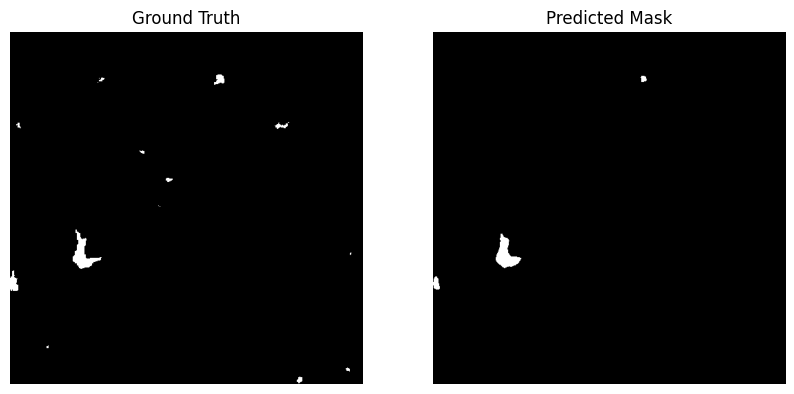

In [12]:
import tifffile as tiff
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image path
image_path = "/kaggle/input/images/images/images/4.tif"

# Load and preprocess the image using tifffile
image = tiff.imread(image_path)

# Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])

image = transform(image).float()  # Convert to float32
image = image.unsqueeze(0)  # Add batch dimension
image = image.to(device)

# ✅ Ensure image is in float32
print(f"Image dtype: {image.dtype}")  # Should print `torch.float32`

# Run inference
model.eval()
with torch.no_grad():
    output = model(image)

# Convert output to binary mask
pred_mask = output.sigmoid().cpu().numpy().squeeze()
pred_mask = (pred_mask > 0.6).astype(np.uint8)  # Binary (0 or 1)

# Load ground truth (assuming it's a PNG image)
label_path = "/kaggle/input/images/labels/labels/4.png"
gt_mask = plt.imread(label_path)

# Normalize GT Mask to Binary (0 or 1)
gt_mask = (gt_mask > 0.001).astype(np.uint8)


# Visualize prediction vs ground truth
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(gt_mask, cmap="gray")
ax[0].set_title("Ground Truth")
ax[0].axis("off")

ax[1].imshow(pred_mask, cmap="gray")
ax[1].set_title("Predicted Mask")
ax[1].axis("off")

plt.show()

In [14]:
# ----------------------- Compute Training Accuracy -----------------------
train_correct = 0
train_total = 0

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        pred_masks = (outputs.sigmoid() > 0.51).float()

        train_correct += (pred_masks == labels).sum().item()
        train_total += labels.numel()

train_accuracy = train_correct / train_total
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

# ---------------------- Evaluate Model on Test Data ----------------------
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        pred_masks = (outputs.sigmoid() > 0.51).cpu().numpy().astype(np.uint8)
        labels = labels.cpu().numpy().astype(np.uint8)

        test_preds.extend(pred_masks.flatten())
        test_labels.extend(labels.flatten())

# Compute Accuracy & F1 Score
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")


Train Accuracy: 97.33%
Test Accuracy: 97.09%
Test F1 Score: 0.7967


In [15]:
pred_mask, gt_mask

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))